## Local Import

* working localy trim the data to ensure you can work with it locally <br/>
*(local computer doesn't have sufficient memory to join all tables so trim down appropriate attributes)*

In [1]:
# If import's not installed pip install all

# import sys
# try: 
#    !{sys.executable} -m pip install plotly --upgrade
#    !{sys.executable} -m pip install geopandas==0.3.0
#    !{sys.executable} -m pip install pyshp==1.2.10
#    !{sys.executable} -m pip install shapely==1.6.3
#    !{sys.executable} -m pip install "notebook>=5.3" "ipywidgets>=7.2"
#    !{sys.executable} -m pip install chart_studio
#    !{sys.executable} -m pip install plotly-geo
#    !{sys.executable} -m pip install folium
# except ImportError: 
#    print("already installed")

# I also added npextentions found (https://github.com/ipython-contrib/jupyter_contrib_nbextensions/blob/master/README.md)
# used conda install so it all came prepacaged then I enabled the extention 

In [2]:
# imports | path info | json to pandas dataframe util funciton 
import json, csv, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
import seaborn as sns 

# clustering / unsupervised learning import
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


# plotly imports 
import plotly
from plotly import __version__
print('running plotly = {}'.format(__version__))
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go

# path info
root_path = "/Users/2015mbp16gb256gb/Documents/school/Fall_2019/4502-Data_Mining/Group_Project/Group1/yelp_dataset/"
rbu_path = root_path + "rbu_merge.json"
filtered_merge_path = root_path + "filtered_merge.json"

# converstion util function
def JSON_to_dataFrame(file): 
    
    fp = open(file, encoding="utf8")
    json_obj = [ json.loads(x) for x in fp.readlines() ] 
    df = pd.DataFrame(json_obj)
    fp.close
    return df

# for plotly ofline 
init_notebook_mode(connected=True)

running plotly = 4.2.1


### Reviewing The Buiness Data

In [ ]:
# add text to plot 
%%time

business_df = JSON_to_dataFrame(root_path + "business.json")
business_df['text'] = business_df['state'] + ', ' + business_df['city']

In [ ]:
# display states/province in business file
business_df.groupby('state').state.count()

* 11 main states found

### Kmeans

* Kmeans can be sensative to outliers but most of the information is naturally clumped so we dont have to worry 

In [ ]:
# find all kmeans and groups
def find_df_groups_plus_kmeans(df, lat, lon, n_clusters): 
    # transform the data 
    coordinates_df = df[[lat, lon]].copy()

    pca = PCA(n_components=2)
    coordinates = pca.fit_transform(coordinates_df)
    
    #Train model
    kmeans = KMeans(n_clusters=n_clusters).fit(coordinates)
    
    # assign lables
    df['labels'] = pd.DataFrame(kmeans.labels_)
    
    return (df, kmeans)

In [ ]:
# plot elbo method
Sum_of_squared_distances = []
K = 15

for k in range(1, K):
    business_df, km = find_df_groups_plus_kmeans(business_df, 'latitude', 'longitude', k)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
# group using k=10
n_clusters = 10
business_df, km = find_df_groups_plus_kmeans(business_df, 'latitude', 'longitude', n_clusters)

*Lets see what states connect to to clusters*

In [ ]:
# group the cluster and evaluate lables
groupby_lables = business_df.groupby('labels').agg(lambda x:x.value_counts().index[0])
state_lables = list(groupby_lables['state'])
cnt = 0
for i in state_lables: 
    print(cnt, i)
    cnt+=1

In [ ]:
# let's plot cluster information for nationwide visualization"""
"""
import plotly.graph_objects as go

fig = go.Figure(data=go.Scattergeo(
        lon = business_df['longitude'],
        lat = business_df['latitude'],
        text = business_df['text'],
        mode = 'markers',
        marker_color = business_df['labels'],
        ))

fig.update_layout(
        title = 'US Cluster<br>(hover for spicific informaiton)',
        geo_scope='usa',
    )
fig.show()
"""

![img](map.png)

#### Deeper look at clustered business data

In [ ]:
# look at the difference between the review count and stars
national_review_mean = business_df["review_count"].mean()
national_stars_mean = business_df["stars"].mean()
print("national_stars_mean = ", national_stars_mean)
print("national_review_mean = ", national_review_mean)

In [ ]:
# means of the clustered info
def sortSecond(val): 
    return val[1] 

review_count = []
rating_stars = []
ratio_open_close = []
count = []
for n in range(n_clusters):
    indexes = business_df[business_df["labels"] != n].index
    temp = business_df.copy()
    temp.drop(indexes, inplace=True)
    rating_stars.append((n, temp["stars"].mean()))
    review_count.append((n, temp["review_count"].mean()))
    count.append((n, temp.count()))
    ratio_open_close.append((n, 1 - temp["is_open"].sum() / temp["is_open"].count() ))

print("Star's mean per cluster = ")
rating_stars.sort(key = sortSecond, reverse = True)
for i, value in rating_stars: 
    print(state_lables[i], value)
    
review_count.sort(key = sortSecond, reverse = True)
print("\nReview_count's mean per cluster = ")
for i, value in review_count: 
    print(state_lables[i], value) 
    
ratio_open_close.sort(key = sortSecond, reverse = True)    
print("\nRatio of closed businesses per cluster = ")
for i, value in ratio_open_close: 
    print(state_lables[i], "=", value) 
    
print("\nCount per cluster = ")
for i, value in count: 
    print("--"+state_lables[i]+"--",value)

*********
### Merging Files and filter out anything not in the NV cluster
* merge review, business, and user. Clean format to ensure no merge conflicts

In [15]:
%%time

review_df = JSON_to_dataFrame(root_path + "review.json")
business_df = JSON_to_dataFrame(root_path + "business.json")
user_df = JSON_to_dataFrame(root_path + "user.json")
# tip_df = JSON_to_dataFrame(root_path + "tip.json")                     /not used
# checkin_df = JSON_to_dataFrame(root_path + "checkin.json")             /not used

CPU times: user 3min 24s, sys: 6min 16s, total: 9min 40s
Wall time: 16min 26s


In [16]:
# utility function to make a dict of columns with table name added
# used for the renaming of column names
def make_columns(lst, base):
    ret = {}
    for i in lst:
        ret[i] = base + '_' + i
    return ret

In [17]:
# return dataframe with column names updated to "table + _column_name"
def process_df(a_df, table): 

    col_list = [i for i in a_df]
    new_dict = make_columns(col_list, table)
    return a_df.rename(columns=new_dict)

In [ ]:
%%time

# review col = ['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text', 'useful', 'user_id']

# ***Update review_df*** 
# review_drop = ['cool','funny']
# review_df = review_df.drop(review_drop, axis=1)

review_df = process_df(review_df, 'review')

In [ ]:
%%time

# business col = 
# ['address','attributes','business_id','categories','city','hours','is_open',              
# 'latitude','longitude','name','postal_code','review_count','stars','state']                              

# ***Update business_df***
# business_drop = ['address', 'postal_code']
# business_df = business_df.drop(business_drop, axis=1)

find_NV = rbu_merge[rbu_merge['labels'] == 0].copy()

business_df = process_df(business_df, 'business')

In [ ]:
%%time

rb_merge = pd.merge(review_df, business_df, left_on='review_business_id', right_on='business_business_id', how='inner')

In [ ]:
%%time

# user col = 
# ['average_stars','compliment_cool','compliment_cute','compliment_funny','compliment_hot','compliment_list',           
# 'compliment_more','compliment_note','compliment_photos','compliment_plain','compliment_profile','compliment_writer', 
# 'cool','elite','fans','friends','funny','name','review_count','useful','user_id','yelping_since']   

# ***Update _user_df***
user_drop = ['average_stars','compliment_cool','compliment_cute','compliment_funny','compliment_hot','compliment_list','compliment_more','compliment_note','compliment_photos','compliment_plain','compliment_profile','compliment_writer','cool', 'elite', 'fans','friends','funny']
user_df = user_df.drop(user_drop, axis=1)

user_df = process_df(user_df, 'user')

In [ ]:
%%time

rbu_merge = pd.merge(rb_merge, user_df, left_on='review_user_id', right_on='user_user_id', how='inner')

In [ ]:
%%time

rbu_drop = ['review_business_id','review_user_id']
rbu_merge = rbu_merge.drop(rbu_drop, axis=1)

In [ ]:
# drop any elements not in the cluster to clean
rbu_merge, km = find_df_groups_plus_kmeans(rbu_merge, 'business_latitude', 'business_longitude', n_clusters)
filtered_merge = rbu_merge[rbu_merge['labels'] == 0].copy()

*********
### Write Merged DataFrame Back To Json file for quicker processing

In [3]:
# convert df to json format util funciton
def df_to_json(df, path):
    new_dict = {}
    num_col = len([i for i in df])

    with open(r'{}'.format(path), 'w') as writer: 

        for row in df.itertuples():
            
            for idx, col in enumerate(df): 
                if type(row[idx+1]) == int: 
                    new_dict[col] = int(row[idx+1])
                if type(row[idx+1]) == float: 
                    new_dict[col] = float(row[idx+1])
                else: 
                    new_dict[col] = str(row[idx+1])
                
            writer.write(json.dumps(new_dict) + '\n')
            new_dict = {}         



In [ ]:
%%time 

df_to_json(filtered_merge, filtered_merge_path)

****
## (Start) Open "filtered_merge" file for further processing

In [4]:
%%time

merged_df = JSON_to_dataFrame(filtered_merge_path)
merged_df.head(2)

CPU times: user 1min 25s, sys: 1min 48s, total: 3min 13s
Wall time: 3min 38s


,review_review_id,review_stars,review_useful,review_text,review_date,business_business_id,business_name,business_city,business_state,business_latitude,...,business_is_open,business_attributes,business_categories,business_hours,user_user_id,user_name,user_review_count,user_yelping_since,user_useful,labels
0,Q1sbwvVQXV2734tPgoKj4Q,1.0,6,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36,ujmEBvifdJM6h6RLv4wQIg,MountainView Hospital,Las Vegas,NV,36.215546,...,1,"{'ByAppointmentOnly': 'False', 'GoodForKids': ...","Fitness & Instruction, Doctors, Health & Medic...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",hG7b0MtEbXx5QzbzE6C_VA,Stefan,10,2008-07-10 17:24:47,18,0
1,oy8f3bxyl7zZJFDQ5edtIA,1.0,3,6 plus hours in the ER on a Tuesday Morning gr...,2013-03-27 14:17:13,ujmEBvifdJM6h6RLv4wQIg,MountainView Hospital,Las Vegas,NV,36.215546,...,1,"{'ByAppointmentOnly': 'False', 'GoodForKids': ...","Fitness & Instruction, Doctors, Health & Medic...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",hG7b0MtEbXx5QzbzE6C_VA,Stefan,10,2008-07-10 17:24:47,18,0


*It looks like the business star ratings are more of a normal distribution than the review stars. we will use this attribute compair to 5 star ratings for businesses.* 

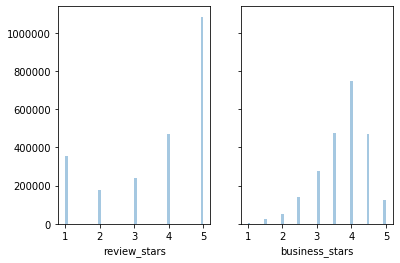

In [5]:
# call regplot on each axes
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

sns.distplot(merged_df.review_stars, kde=False, ax=ax1)
sns.distplot(merged_df.business_stars, kde=False, ax=ax2)

#sns.set(rc={'figure.figsize':(10,5)})

In [6]:
# thoughts on what can be done with the data


# Nieve Base 
# first use business 5 star to classify as either 1 or 0
# then find the calssifications as P("x-class" | "5 star = yes") * P("5 star = yes")
# do this for all classificatoins to get the probability a business in this classification will get a 5 star rating

# the rule R can be assessed by coverage and accuracy
# coverage = the percentage of tuples that are covered by the rule
# accuracy = the percentage of tuples that the rule can correctly classify

# look into the information gain for each attribute given a classification and 5 star
# to do this we will have to transpose each attributs into a nominal or binary value
# (within each category) total "5 star = yes" = P and total "5 star = no" = N
# I(P,N) = - (P/total in dataset) * log_2(P/total in dataset) - (N/total in data set) * log_2(N/total in dataset)
# # Info_Dataset(D) = I(total number of yes, total number of no)
# to get the information gain form the category attribute we need P and N from each category to
# Info_category(D) = (# of each in category) / (total in dataset) * I(P,N) + Sum(X) for X as each category
# Info_Dataset(D) - Info_category(D) 
# do this for all attribues to find what to split on 

# coverage (R) = (how many entries meet the "x-class" | "5 star = yes" criteria) / (total number of entries)
# accurecy (R) = (num of "5 star = yes") / (how many entries meet the "x-class" | "5 star = yes" criteria)

# useful vs avg stars
# cool vs average stars
# funny vs average stars
# number of friends vs avg stars


## Naive Bayes - Find the probability of a category attaining a 5 star rating

### Add attributes 
1 or 0 depending on five_star avg

In [7]:
# if business has rating of 5 star add 1 to list othrwise 0
# add this information as a new column
def update_list(val): 
    if val == 5: 
        return 1
    else: 
        return 0
    
merged_df['five_star_business'] = [update_list(x) for x in merged_df['business_stars'] ]


1 or 0 depending on local chain

In [8]:
# if business has multiple entries calassify as chain with a 1 otherwise 0
unique_list = []

def check_unique(lst, entry): 
    for i in lst: 
        if i == entry: 
            return 1
        
    lst.append(entry)
    return 0

merged_df['is_chain'] = [check_unique(unique_list, x) for x in merged_df.business_name]


### Predict (X) geting a 5 star rating; where X is a given category
(first lets look at the probability of getting a five star vs not getting a five star)

In [9]:
# find the probability of yes and no
N = merged_df['five_star_business'].count()

num_yes = merged_df[merged_df['five_star_business']==1].five_star_business.count()
num_no = N - num_yes

print("C_1 = yes (five star rating)")
print("C_2 = no  (five star rating)")
print("P(C_i|X) = P(X| C_i) P(C_i)")
print("P(C_i)")

stars_yes = num_yes / N
stars_no = num_no / N
print("P(five_star = \"yes\") = {}/{} = {}".format(num_yes, N, stars_yes)) 
print("P(five_star = \"no\") = {}/{} = {}".format(num_no, N, stars_no))


C_1 = yes (five star rating)
C_2 = no  (five star rating)
P(C_i|X) = P(X| C_i) P(C_i)
P(C_i)
P(five_star = "yes") = 126073/2322430 = 0.05428495153782891
P(five_star = "no") = 2196357/2322430 = 0.9457150484621711


(now determin probabilities based on a given calss)

In [10]:
# function for calculating pobabilities
def prob_entry(df, yes_total, no_total): 
    five_star_yes = df[df['five_star_business']==1].five_star_business.count()
    five_star_no = df[df['five_star_business']==0].five_star_business.count()
    prob = (five_star_yes / yes_total, five_star_no / no_total)
    return prob

def calc_probabilities(df, column_for_prob, num_yes, num_no): 
    prob_five_star = []
    # group and find the probabilities based on group
    for name, group in df.groupby(column_for_prob): 
        prob_five_star.append((name, prob_entry(group, num_yes, num_no)))
        
    # split array into lists based on attibute
    list_of_column_for_prob = []
    list_of_prob_yes = []
    list_of_porb_no = []

    for name, (yes, no) in prob_five_star: 
        list_of_column_for_prob.append(name)
        list_of_prob_yes.append(yes)
        list_of_porb_no.append(no)
        
    # combine lists and add to dataframe    
    zippedList =  list(zip(list_of_column_for_prob, list_of_prob_yes, list_of_porb_no))
    
    return pd.DataFrame(zippedList, columns = [column_for_prob, 'yes_prob', 'no_prob'])

def add_prob_five_star_yes(df, stars_yes, stars_no):
    df['P(category|star=yes)*P(star=yes)'] = df['yes_prob'] * stars_yes
    df['P(category|star=no)*P(star=no)'] = df['no_prob'] * stars_no
    return df

In [63]:
def tokenize(string): 
    token = string.split(',')
    temp = []
    for i in token: 
        temp.append(i.strip())
    
    return temp
 


def take_dict(df): 
    categories_dic = {}
    
    for idx in df.index:  
        ret_array = tokenize(merged_df["business_categories"][idx])
        for i in ret_array: 
            if i not in categories_dic.keys():
                categories_dic[i] = (0, 0)
            else:
                if merged_df.five_star_business[idx] == 1: 
                    (num_count_five, total_review_count) = categories_dic[i]
                    num_count_five += 1
                    total_review_count += 1
                    categories_dic[i] = (num_count_five, total_review_count)
                else: 
                    (num_count_five, total_review_count) = categories_dic[i]
                    total_review_count += 1
                    categories_dic[i] = (num_count_five, total_review_count)
            
    return categories_dic

test = take_dict(merged_df)

In [65]:
test

{'Fitness & Instruction': (6120, 24226),
 'Doctors': (3845, 35806),
 'Health & Medical': (16852, 97915),
 'Active Life': (11340, 91447),
 'Gyms': (2609, 15485),
 'Emergency Rooms': (4, 1269),
 'Medical Centers': (738, 12216),
 'Hospitals': (36, 5385),
 'Discount Store': (194, 6583),
 'Food': (10668, 490775),
 'Drugstores': (122, 10064),
 'Electronics': (667, 11804),
 'Mobile Phones': (638, 9132),
 'Department Stores': (31, 12387),
 'Grocery': (211, 24143),
 'Fashion': (2485, 41561),
 'Shopping': (24358, 181282),
 'Television Stations': (5, 381),
 'Mass Media': (273, 1316),
 'Hotels & Travel': (3543, 210767),
 'Hotels': (588, 159745),
 'Restaurants': (9538, 1392717),
 'Italian': (526, 125508),
 'Buffets': (0, 88737),
 'American (Traditional)': (901, 264145),
 'Arts & Entertainment': (6582, 265340),
 'Event Planning & Services': (12587, 267784),
 'Casinos': (784, 145380),
 'Automotive': (11707, 98826),
 'Auto Parts & Supplies': (1913, 21889),
 'Pubs': (173, 35683),
 'Bars': (2230, 367188

In [37]:
merged_df[merged_df['business_categories'] == '& Probates']

,review_review_id,review_stars,review_useful,review_text,review_date,business_business_id,business_name,business_city,business_state,business_latitude,...,business_categories,business_hours,user_user_id,user_name,user_review_count,user_yelping_since,user_useful,labels,five_star_business,is_chain


##### P(Category| C_i) 

In [11]:
prob_categories_df = calc_probabilities(merged_df, 'business_categories', num_yes, num_no)

##### P(Category| C_i) P(C_i)

In [12]:
test = add_prob_five_star_yes(prob_categories_df, stars_yes, stars_no)

#### Prediction

In [18]:
prob_categories_df.sort_values(by="yes_prob", ascending=False)

,business_categories,yes_prob,no_prob,P(category|star=yes)*P(star=yes),P(category|star=no)*P(star=no)
20960,"Tea Rooms, Desserts, Cafes, Restaurants, Food,...",0.012469,0.000000,0.000677,0.000000
21575,"Vehicle Wraps, Shopping, Auto Customization, C...",0.005774,0.000000,0.000313,0.000000
1789,"Automotive, Auto Repair",0.005711,0.000478,0.000310,0.000452
4057,"Casinos, Magicians, Event Planning & Services,...",0.005330,0.000000,0.000289,0.000000
10635,"Home Cleaning, Carpet Cleaning, Air Duct Clean...",0.004616,0.000000,0.000251,0.000000
...,...,...,...,...,...
8267,"Food, Event Planning & Services, Caterers, Bak...",0.000000,0.000005,0.000000,0.000005
8266,"Food, Event Planning & Services, Breakfast & B...",0.000000,0.000062,0.000000,0.000059
8265,"Food, Ethnic Food, Specialty Food, Chinese, Re...",0.000000,0.000028,0.000000,0.000026
8264,"Food, Ethnic Food, Specialty Food",0.000000,0.000002,0.000000,0.000002


In [14]:
prob_categories_df.sort_values(by="P(category|star=yes)*P(star=yes)", ascending=False)[:2]

,business_categories,yes_prob,no_prob,P(category|star=yes)*P(star=yes),P(category|star=no)*P(star=no)
20960,"Tea Rooms, Desserts, Cafes, Restaurants, Food,...",0.012469,0.0,0.000677,0.0
21575,"Vehicle Wraps, Shopping, Auto Customization, C...",0.005774,0.0,0.000313,0.0


#### Coverage and Accuracy

In [ ]:
def coverage_accuracy(df, yes_total): 
    five_star_yes = df[df['five_star_business']==1].five_star_business.count()
    count = df.five_star_business.count()
    coverage = (five_star_yes / yes_total)
    accuracy = five_star_yes / count
    return (coverage, accuracy)

columns = 'business_categories'
probs = []

for name, group in df.groupby(columns): 
    probs.append(coverage_accuracy(, yes_total))

### Visualize clustered K-mans NV informaiton

once the we have a resonable amount of business lets visualize

In [ ]:
# find unique businesses
def make_unique(df, col1): 
    unique = []
    booliens = []

    for x in df[col1]:
        if x not in unique:
            booliens.append(True)
            unique.append(x)
        else:
            booliens.append(False)

    return booliens

booliens = []

arg1 = 'business_business_id'
booliens = make_unique(merged_df, arg1)

unique_values = pd.Series(booliens)

# use as filter for unique values
unique_review_df = merged_df[unique_values]

# look at the number of business in the area
unique_review_df.business_business_id.count()

# look at all the businesses with average star rating over 4
unique_review_df[(unique_review_df['business_stars'] > 4) & (unique_review_df['business_is_open'] == '1')].business_stars.count() 

test_df = unique_review_df[(unique_review_df['business_stars'] > 4) & (unique_review_df['business_is_open'] == '1')].copy()



In [ ]:
# visualize location points using folium
import folium
 
NV = (36.188820, -115.207720)
 
# for speed purposes


colors = ['#000000', '#cc0099', '#3186cc']

  
# create empty map zoomed in on San Francisco
m = folium.Map(location=NV, zoom_start=10)


# add a marker for every record in the filtered data, use a clustered view
for lat, lon in zip(test_df['business_latitude'], test_df['business_longitude']):    
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        fill=True,
        ).add_to(m) 

display(m)


********

## Unit Test

In [ ]:
# function to chop file down to in size to test
def JSON_to_dataFrame_2(file): 
    
    fp = open(file, encoding="utf8")
    json_obj = [ json.loads(x) for x in fp.readlines() [-500000:]] 
    df = pd.DataFrame(json_obj)
    fp.close
    return df

# turn part of busines.json file into trunkated file for testing called (test.json)
test_path = root_path + 'test.json' 
parse_DataFrame1(JSON_to_dataFrame_2('business.json'), test_path)

In [ ]:
%%time

# take a small percentage of entries and convert to dataframe 
test_in_path = root_path + 'test.json' 
test_df = JSON_to_dataFrame(test_in_path)

# write that dataframe to file
test_out_path = root_path + 'test_out.json' 
parse_DataFrame1(test_df, test_out_path)

# convert that file back to dataframe (should be the same)
test2_df = JSON_to_dataFrame(test_out_path)

In [ ]:
# util function to compare dataframes
def test_DataFrame_to_Json(a_df_1, a_df_2): 
    
    df_list_1 = []
    df_list_2 = []
    catch_list = []
    
    for row in a_df_1.itertuples():
            
            for idx, col in enumerate(a_df_1):
                df_list_1.append((type(row[idx]), col))
                
    for row_2 in a_df_2.itertuples():
            
            for idx_2, col_2 in enumerate(a_df_2):
                df_list_2.append((type(row[idx_2]), col_2))
                
    for x,y in zip(df_list_1, df_list_2): 
        if x != y: 
            catch_list.append((x, y))
            
    for i in catch_list: 
        print(i)             # dataFrams have different types

In [ ]:
# function to view parts of a file that recieved an error message

def check_input_output(a_test_in_path, a_test_out_path, a_log_path):
    line_count = 0
    char_count = 0
    save1 = ""
    save2 = []
    cnt1 = 0
    cnt2 = 0
    
    with open(a_test_in_path, 'r') as read1, open(a_test_out_path, 'r') as read2: 
        for x, y in zip(read1, read2):
            x = x.strip()
            y = y.strip()
            
            in_line = x.split()
            out_line = y.split()
            for word1, word2 in zip(in_line, out_line):
                
                save2.append(word1)
                
                if cnt1 > 5:
                    save2.pop(0)
                cnt1 = cnt1 + 1

            
                word_list = list(word2)
                
                for char in word_list: 
                    save1 = save1 + char
                    if cnt2 > 70: 
                        save1 = save1[1:]
                    
                    if char_count == 139: 
                        print(save1)
                        print(" ".join(save2))
                        
                    char_count = char_count + 1
                    cnt2 += 1
                
            line_count = line_count + 1
            
check_input_output(test_in_path, test_out_path, log_path)

****
## GCP Import
* login cradentaials provided to work with yelp_db database

In [ ]:
# pip install if you dont have PyMySQL
# import sys
#  !{sys.executable} -m pip install PyMySQL

### MySql Server is nessisary to connect to GCP
* https://dev.mysql.com/downloads/mysql/

In [ ]:
# imports
import pymysql, os, sys, json
from IPython.display import clear_output
import multiprocessing as mp

In [ ]:
# read json file
file = "Group1/review.json"

json_data = open(file, encoding="utf8")
json_obj = [json.loads(x) for x in json_data.readlines()]


In [ ]:
# validate data before inserting
# TODO: check if string is the right type 
# TODO: check for duplicate data
# TODO: check for bad formats (date)

def validate_string(val): 
    if val != None: 
            if type(val) is int: 
                return str(val).encode('utf-8')
            else: 
                return val
            

### Processing takes to long so I used multiprocessing to speed up importing to host
* executing insert into gcp is atomic

this will take over 4 days to import one table for review file! may have to revisit this if we can shrink the information

In [ ]:
# util function to insert each dictionary element
def insert_review(cursor, item, lock): 
          
    review_id = validate_string(item['review_id'])
    business_id = validate_string(item['business_id'])
    cool = validate_string(item['cool'])
    date = validate_string(item['date'])
    funny = validate_string(item['funny'])
    stars = validate_string(item['stars'])
    text = validate_string(item['text'])
    useful = validate_string(item['useful'])
    user_id = validate_string(item['user_id'])
    
    query = "INSERT INTO review(review_id,business_id,cool,date,funny,stars,text,useful,user_id) VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s)"
    args = (review_id, business_id, cool, date, funny, stars, text, useful, user_id)
    lock.acquire()
    cursor.execute(query, args)
    lock.release()
    
    clear_output()
    cnt.value = cnt.value + 1
    print(cnt.value)
    
    

In [ ]:
# connect to GCP MySql db insert data into review table
con = pymysql.connect(host = '104.198.65.208', user='root', password = 'hackme', db = 'yelp_db')

cnt = mp.Value('i', 0)
lock = mp.Lock()
pool = mp.Pool()


try: 
    with con.cursor() as cursor:
        
        # parse json data to SQL
        # use map to update each row in GCP
        result = pool.map([ insert_review(cursor, item, lock) for item in json_obj ])
            
finally:
    con.commit()
    con.close()
    